In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chess
import chess.svg
import json
import time
from pathlib import Path
from enum import Enum
from IPython.display import display, SVG

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2048 
TEST_PATH = Path("./dataset_bitmaps/bitboard_test.npz") 
RESULTS_DIR = Path("experiments/results")
LOGS_DIR = Path("experiments/logs")

# ==========================================
MODEL_NAME = "wide_mlp_v1"
MODEL_TYPE = "WideMLP"
MODEL_PATH = "models" / "wide_mlp_v1.pth"
INPUT_SHAPE = 775
HIDDEN_UNITS = 2048 
OUTPUT_SHAPE = 7
FAILURE_INDICES_PATH = RESULTS_DIR / MODEL_NAME /"run_2026_01_05_wide_mlp_v1_failure_indices.json"   
# ==========================================

In [2]:
class WideMLP(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.network(x)
    
class PyramidalMLP_v2(nn.Module):
    def __init__(self, input_shape=775, output_shape=7):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_shape, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(400, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        return self.network(x)


In [3]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32)
            self.y = torch.tensor(data["y"], dtype=torch.long)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

def get_test_loader():
    dataset = NPZChessDataset(TEST_PATH)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ==========================================
if MODEL_TYPE == "WideMLP":
    model = WideMLP(INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE).to(DEVICE)
elif MODEL_TYPE == "PyramidalMLP":
    model = PyramidalMLP_v2(INPUT_SHAPE, OUTPUT_SHAPE).to(DEVICE)
# ==========================================

try:
    model.load_state_dict(torch.load(MODEL_PATH))
    print(f"Loaded weights from {MODEL_PATH}")
except FileNotFoundError:
    print("Weight file not found! Please check MODEL_PATH.")

model.eval()
print("Model ready.")

Loaded weights from wide_mlp_v1.pth
Model ready.


In [4]:
def generate_saliency_map(model, input_tensor, target_class):
    """
    Computes the gradient of the score for the target class w.r.t the input vector.
    """
    model.eval()
    input_tensor.requires_grad = True

    pred = model(input_tensor)
    score = pred[0, target_class]

    score.backward()
    
    gradients = input_tensor.grad.data.cpu().numpy()[0]
    
    return gradients

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_chess_gradients(gradients):
    """
    Visualizes the gradient vector with clear labeling for chess piece blocks.
    """
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax1.plot(gradients, color="b", linewidth=1, label='Gradient Magnitude')
    channels = ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']
    block_size = 64
    
    # Dynamic Y-limit to place text just above the data
    y_min, y_max = np.min(gradients), np.max(gradients)
    y_range = y_max - y_min
    text_y_pos = y_max + (y_range * 0.05) 
    
    # Add Shading and Labels for each Piece Block
    for i, channel in enumerate(channels):
        start_idx = i * block_size
        end_idx = (i + 1) * block_size
        if i % 2 == 0:
            ax1.axvspan(start_idx, end_idx, color='gray', alpha=0.1, lw=0)
        ax1.axvline(x=end_idx, color='gray', linestyle=':', alpha=0.5)
        ax1.text(start_idx + block_size/2, text_y_pos, channel, 
                 ha='center', va='bottom', fontsize=12, fontweight='bold', color='#333333')

    ax1.set_title('Gradient Sensitivity by Feature Index', fontsize=14, pad=25)
    ax1.set_xlabel('Feature Index')
    ax1.set_ylabel('Gradient Value')
    ax1.set_xlim(0, 767)
    
    ax1.set_ylim(y_min, y_max + (y_range * 0.15))

    ax1.grid(True, axis='y', alpha=0.3, linestyle='--')
    sns.despine()

    plt.tight_layout()
    plt.show()

def plot_chess_heatmap(gradients, fen_str, true_label, pred_label):
    """
    Aggregates gradients from the 12 bitboards (first 768 indices) into a 8x8 grid.
    """
    # Reshape first 768 features into (12 channels, 64 squares)
    # The order of channels : P, N, B, R, Q, K, p, n, b, r, q, k
    piece_grads = gradients[:768].reshape(12, 64)
    
    # Sum absolute gradients across all piece channels to get importance per square
    # Shape becomes (64,)
    saliency = np.sum(np.abs(piece_grads), axis=0)
    
    # Reshape into 8x8 board
    heatmap = saliency.reshape(8, 8)
    
    # Matplotlib plots 0 at top-left by default, but chess Index 0 is a1 (bottom-left).
    # We need to flip vertically for imshow to put Rank 8 at top.
    heatmap = np.flipud(heatmap) 

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(heatmap, cmap="viridis", alpha=0.7, zorder=2, ax=ax, cbar=False)
    ax.set_title(f"Saliency Map (True: {true_label}, Pred: {pred_label})")
    plt.show()
    print("Actual Board Position:")
    display(chess.svg.board(chess.Board(fen_str), size=350))

def vector_to_fen(vector):
    """
    Reconstructs a FEN string from the 775-dim bitboard vector.
    """

    index_to_piece = {
        0: 'P', 1: 'N', 2: 'B', 3: 'R', 4: 'Q', 5: 'K',
        6: 'p', 7: 'n', 8: 'b', 9: 'r', 10: 'q', 11: 'k'
    }
    
    board = chess.Board(None) 
    
    for piece_idx in range(12):
        for square in range(64):
            idx = piece_idx * 64 + square
            if vector[idx] == 1:
                piece = chess.Piece.from_symbol(index_to_piece[piece_idx])
                board.set_piece_at(square, piece)
                
    board.turn = chess.WHITE if vector[768] == 1 else chess.BLACK

    castling_fen = ""
    if vector[769] == 1: castling_fen += "K"
    if vector[770] == 1: castling_fen += "Q"
    if vector[771] == 1: castling_fen += "k"
    if vector[772] == 1: castling_fen += "q"
    if castling_fen == "": castling_fen = "-"
    
    board.set_castling_fen(castling_fen)
    
    return board.fen()

Analyzing Test Sample Index: 105
FEN: 8/8/8/8/7k/1R2p3/4pp2/4K3 w - - 0 1
True Label: 0 | Predicted: 6
Error Magnitude: 6


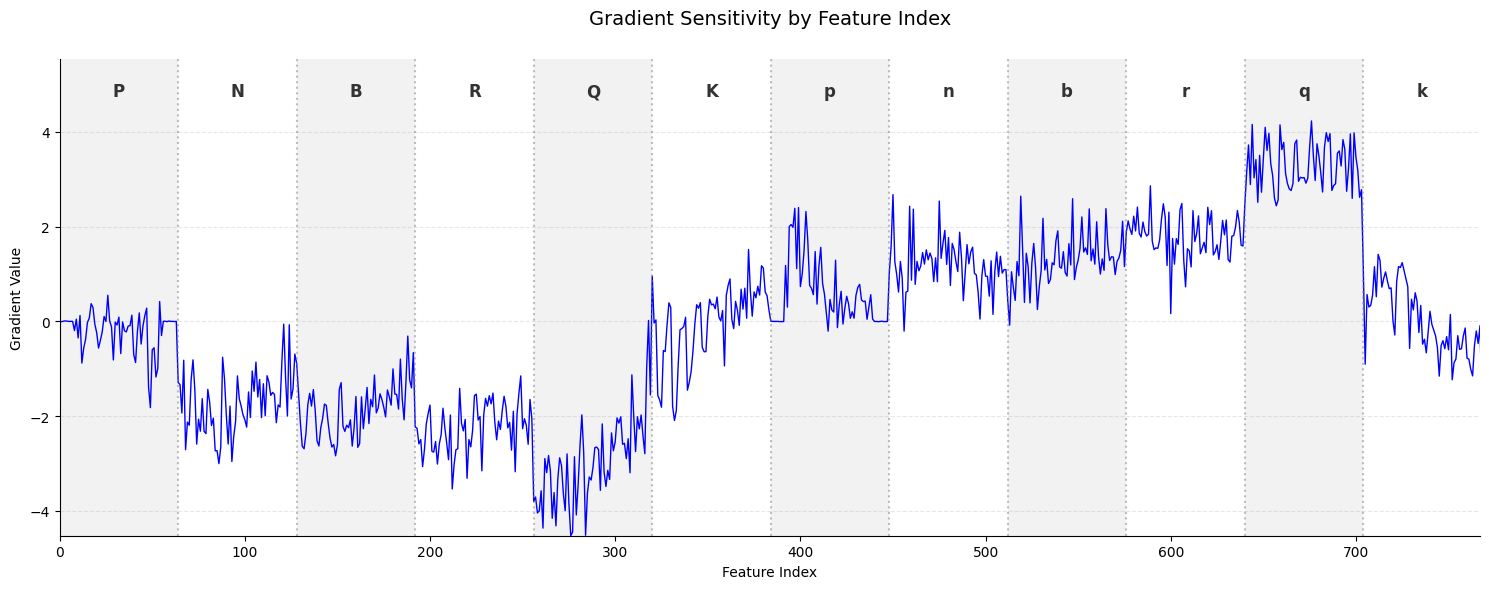

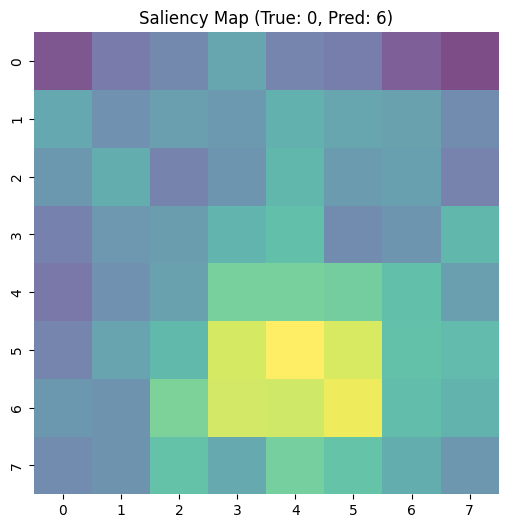

Actual Board Position:


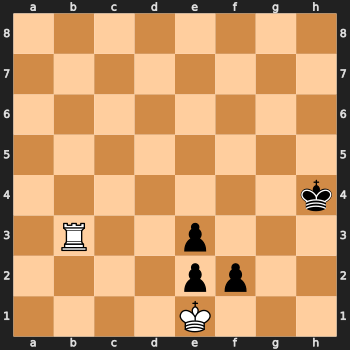

In [5]:
with open(FAILURE_INDICES_PATH, "r") as f:
    failure_data = json.load(f)

# ==========================================
ERROR_MAGNITUDE = "6"  # Choose from '3', '4', '5', '6' 
FAILURE_IDX_IN_LIST = 0 # Pick the Nth failure in that category
# ==========================================

dataset_idx = failure_data[ERROR_MAGNITUDE][FAILURE_IDX_IN_LIST]

# Load that specific sample
dataset = NPZChessDataset(TEST_PATH)
X_sample, y_sample = dataset[dataset_idx]
    
# Unsqueeze so [775] > [1, 775] as model expects batch
X_input = X_sample.unsqueeze(0).to(DEVICE)

# Predict
model.eval()
pred_logits = model(X_input)
pred_label = torch.argmax(pred_logits, dim=1).item()

# Generate Saliency to see why it predicted the wrong class
grads = generate_saliency_map(model, X_input, pred_label)

# Reconstruct FEN for visualization
reconstructed_fen = vector_to_fen(X_sample)

print(f"Analyzing Test Sample Index: {dataset_idx}")
print(f"FEN: {reconstructed_fen}")
print(f"True Label: {y_sample.item()} | Predicted: {pred_label}")
print(f"Error Magnitude: {abs(y_sample.item() - pred_label)}")

plot_chess_gradients(grads)
plot_chess_heatmap(grads, fen_str=reconstructed_fen, true_label=y_sample.item(), pred_label=pred_label)

Loading existing log from experiments\logs\wide_mlp_v1\accuracy_vs_piece_count.csv...


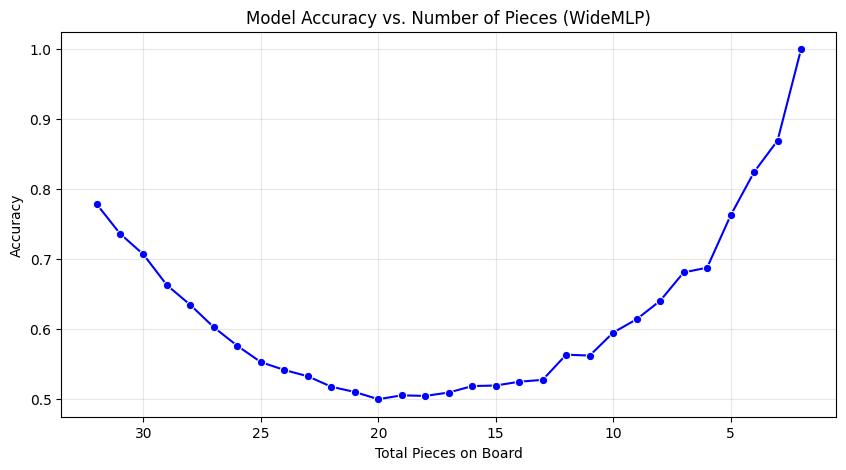

In [6]:
PIECE_ACC_LOG = LOGS_DIR / MODEL_NAME / "accuracy_vs_piece_count.csv"

def compute_piece_accuracy(model, dataloader):
    results = []
    model.eval()
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            preds = model(X).argmax(dim=1)
            

            piece_counts = X[:, :768].sum(dim=1).cpu().numpy()
            correct = (preds == y).cpu().numpy()
            
            for count, is_correct in zip(piece_counts, correct):
                results.append({"piece_count": int(count), "correct": int(is_correct)})
                
    df = pd.DataFrame(results)
    # Group by piece count and calc mean accuracy
    summary = df.groupby("piece_count")["correct"].mean().reset_index()
    summary.rename(columns={"correct": "accuracy"}, inplace=True)
    return summary

# Check if exists
if PIECE_ACC_LOG.exists():
    print(f"Loading existing log from {PIECE_ACC_LOG}...")
    df_piece_acc = pd.read_csv(PIECE_ACC_LOG)
else:
    test_loader = get_test_loader()
    df_piece_acc = compute_piece_accuracy(model, test_loader)
    df_piece_acc.to_csv(PIECE_ACC_LOG, index=False)
    print(f"Saved new log to {PIECE_ACC_LOG}")


plt.figure(figsize=(10, 5))
sns.lineplot(data=df_piece_acc, x="piece_count", y="accuracy", marker="o", color="blue")
plt.title(f"Model Accuracy vs. Number of Pieces ({MODEL_TYPE})")
plt.xlabel("Total Pieces on Board")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

Loading existing log from experiments\logs\wide_mlp_v1\accuracy_vs_phase_granular.csv...


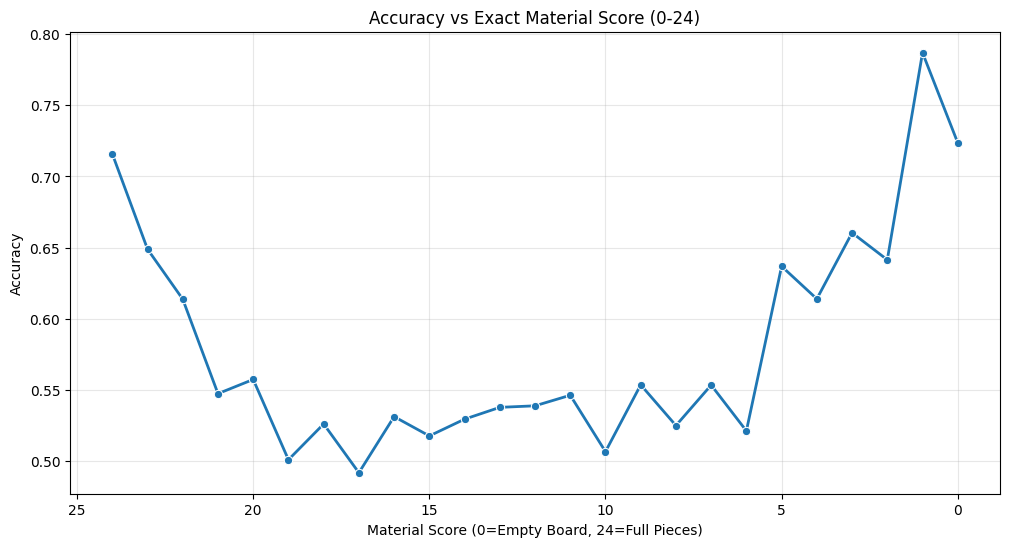

In [7]:
PHASE_ACC_LOG = LOGS_DIR / MODEL_NAME / "accuracy_vs_phase.csv"

def compute_phase_accuracy(model, dataloader):
    results = []
    model.eval()
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            preds = model(X).argmax(dim=1)

            X_cpu = X.cpu().numpy()
            correct_batch = (preds == y).cpu().numpy() 
            
            n_count = np.sum(X_cpu[:, 64:128], axis=1) + np.sum(X_cpu[:, 448:512], axis=1)
            b_count = np.sum(X_cpu[:, 128:192], axis=1) + np.sum(X_cpu[:, 512:576], axis=1)
            r_count = np.sum(X_cpu[:, 192:256], axis=1) + np.sum(X_cpu[:, 576:640], axis=1)
            q_count = np.sum(X_cpu[:, 256:320], axis=1) + np.sum(X_cpu[:, 640:704], axis=1)
            
            # Formula: N*1 + B*1 + R*2 + Q*4
            phases = (n_count * 1) + (b_count * 1) + (r_count * 2) + (q_count * 4)
            phases = np.minimum(phases, 24).astype(int)

            for phase_score, is_corr in zip(phases, correct_batch):
                results.append({
                    "material_score": phase_score, 
                    "correct": int(is_corr)
                })

    df = pd.DataFrame(results)
    summary = df.groupby("material_score", observed=False)["correct"].mean().reset_index()    
    return summary

if PHASE_ACC_LOG.exists():
    print(f"Loading existing log from {PHASE_ACC_LOG}...")
    df_phase = pd.read_csv(PHASE_ACC_LOG)
else:
    test_loader = get_test_loader()
    df_phase = compute_phase_accuracy(model, test_loader)
    df_phase.to_csv(PHASE_ACC_LOG, index=False)
    print(f"Saved new log to {PHASE_ACC_LOG}")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_phase, x="material_score", y="correct", marker="o", linewidth=2)
plt.title("Accuracy vs Exact Material Score (0-24)")
plt.xlabel("Material Score (0=Empty Board, 24=Full Pieces)")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

Scanning for 'Positional Wins' (Equal Material, but Decisive Result)...
Saved new positional report to experiments\logs\wide_mlp_v1\positional_report.json
----------------------------------------
POSITIONAL UNDERSTANDING REPORT
----------------------------------------
Total Positions Analyzed: 200455
Model Accuracy:           58.69%
----------------------------------------
Breakdown of Errors:
  Mistook for Draw:       18113
  Picked Wrong Winner:    64694
----------------------------------------


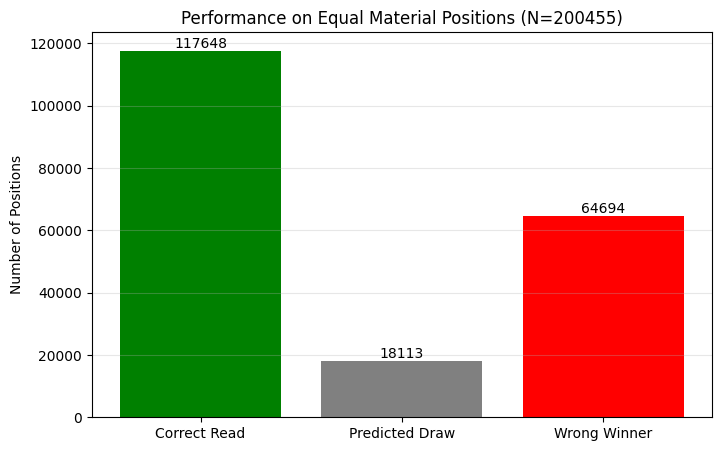

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns

POSITIONAL_LOG = LOGS_DIR / MODEL_NAME / "positional_report.json"

def generate_positional_report(model, dataloader, device):
    print("Scanning for 'Positional Wins' (Equal Material, but Decisive Result)...")
    model.eval()
    
    total_material_equal_positions = 0
    correct_positional_reads = 0
    predicted_draw_count = 0        # Model predicted Draw (Class 3)
    predicted_wrong_winner_count = 0 # Model predicted wrong winner but not Draw

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            
            X_cpu = X.cpu().numpy()
            y_cpu = y.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            # --- CALCULATE MATERIAL FOR WHITE & BLACK ---
            w_pawns   = np.sum(X_cpu[:, 0:64], axis=1)
            w_knights = np.sum(X_cpu[:, 64:128], axis=1)
            w_bishops = np.sum(X_cpu[:, 128:192], axis=1)
            w_rooks   = np.sum(X_cpu[:, 192:256], axis=1)
            w_queens  = np.sum(X_cpu[:, 256:320], axis=1)
            w_score = (w_pawns * 1) + (w_knights * 3) + (w_bishops * 3) + (w_rooks * 5) + (w_queens * 9)

            b_pawns   = np.sum(X_cpu[:, 384:448], axis=1)
            b_knights = np.sum(X_cpu[:, 448:512], axis=1)
            b_bishops = np.sum(X_cpu[:, 512:576], axis=1)
            b_rooks   = np.sum(X_cpu[:, 576:640], axis=1)
            b_queens  = np.sum(X_cpu[:, 640:704], axis=1)
            b_score = (b_pawns * 1) + (b_knights * 3) + (b_bishops * 3) + (b_rooks * 5) + (b_queens * 9)
            
            is_equal_material = (w_score == b_score)
            is_decisive = (y_cpu != 3)
            target_indices = np.where(is_equal_material & is_decisive)[0]
            
            # --- EVALUATE ---
            if len(target_indices) > 0:
                total_material_equal_positions += len(target_indices)
                
                relevant_preds = preds_cpu[target_indices]
                relevant_labels = y_cpu[target_indices]
                
                matches = (relevant_preds == relevant_labels)
                correct_positional_reads += np.sum(matches)
                
                errors = ~matches
                error_preds = relevant_preds[errors]
                
                predicted_draw_count += np.sum(error_preds == 3)
                predicted_wrong_winner_count += np.sum(error_preds != 3)

    accuracy = 0
    if total_material_equal_positions > 0:
        accuracy = correct_positional_reads / total_material_equal_positions

    report = {
        "total_positions": int(total_material_equal_positions),
        "correct_reads": int(correct_positional_reads),
        "accuracy": float(accuracy),
        "errors": {
            "predicted_draw": int(predicted_draw_count),
            "predicted_wrong_winner": int(predicted_wrong_winner_count)
        }
    }
    
    return report

if POSITIONAL_LOG.exists():
    print(f"Loading existing positional report from {POSITIONAL_LOG}...")
    with open(POSITIONAL_LOG, "r") as f:
        report = json.load(f)
else:
    test_loader = get_test_loader()
    report = generate_positional_report(model, test_loader, DEVICE)
   
    with open(POSITIONAL_LOG, "w") as f:
        json.dump(report, f, indent=4)
    print(f"Saved new positional report to {POSITIONAL_LOG}")

# --- Reporting & Plotting ---
total = report["total_positions"]
if total == 0:
    print("No equal material positions found.")
else:
    correct = report["correct_reads"]
    err_draw = report["errors"]["predicted_draw"]
    err_wrong = report["errors"]["predicted_wrong_winner"]
    acc = report["accuracy"]
    
    print("-" * 40)
    print(f"POSITIONAL UNDERSTANDING REPORT")
    print("-" * 40)
    print(f"Total Positions Analyzed: {total}")
    print(f"Model Accuracy:           {acc:.2%}")
    print("-" * 40)
    print("Breakdown of Errors:")
    print(f"  Mistook for Draw:       {err_draw}")
    print(f"  Picked Wrong Winner:    {err_wrong}")
    print("-" * 40)

    # Simple Bar Plot
    plt.figure(figsize=(8, 5))
    categories = ['Correct Read', 'Predicted Draw', 'Wrong Winner']
    values = [correct, err_draw, err_wrong]
    
    bars = plt.bar(categories, values, color=['green', 'gray', 'red'])
    plt.title(f"Performance on Equal Material Positions (N={total})")
    plt.ylabel("Number of Positions")
    plt.grid(axis='y', alpha=0.3)
    
    # Add counts on top
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')
        
    plt.show()